In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/age-gender')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhqGpRCJ3VgQieaj8lvjHe78LEz0cezH3UL9FPRNBeG-SR86SfwYBY
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

In [ ]:
#load data
fold0 = pd.read_csv("face2/fold_0_data.txt",sep = "\t" )

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
total_data = pd.concat([fold0], ignore_index=True)

In [ ]:
imp_data = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
imp_data.info()
img_path = []
for row in total_data.iterrows():
    path = "face2/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
imp_data['img_path'] = img_path

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     1586 non-null   object
 1   gender  1585 non-null   object
 2   x       1586 non-null   int64 
 3   y       1586 non-null   int64 
 4   dx      1586 non-null   int64 
 5   dy      1586 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 74.5+ KB


In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(imp_data.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        imp_data.age.loc[idx] = age_mapping_dict[each]
imp_data = imp_data.drop(labels=drop_labels, axis=0) #droped None values
imp_data.age.value_counts(dropna=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


25-32    950
4-6      258
0-2      238
38-43     71
60+       30
48-53     22
15-20     10
8-13       6
Name: age, dtype: int64

In [ ]:
imp_data = imp_data.dropna()
clean_data = imp_data[imp_data.gender != 'u'].copy()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 0 to 1585
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1585 non-null   object
 1   gender    1585 non-null   object
 2   x         1585 non-null   int64 
 3   y         1585 non-null   int64 
 4   dx        1585 non-null   int64 
 5   dy        1585 non-null   int64 
 6   img_path  1585 non-null   object
dtypes: int64(4), object(3)
memory usage: 99.1+ KB


In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}
clean_data['gender'] = clean_data['gender'].apply(lambda g: gender_to_label_map[g])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,25-32,0,0,414,1086,1383,face2/30601258@N03/coarse_tilt_aligned_face.1....
1,25-32,1,301,105,640,641,face2/30601258@N03/coarse_tilt_aligned_face.2....
2,25-32,0,2395,876,771,771,face2/30601258@N03/coarse_tilt_aligned_face.1....
3,25-32,1,752,1255,484,485,face2/30601258@N03/coarse_tilt_aligned_face.3....
4,25-32,1,175,80,769,768,face2/30601258@N03/coarse_tilt_aligned_face.2....


In [ ]:
age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}
clean_data['age'] = clean_data['age'].apply(lambda age: age_to_label_map[age])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,face2/30601258@N03/coarse_tilt_aligned_face.1....
1,4,1,301,105,640,641,face2/30601258@N03/coarse_tilt_aligned_face.2....
2,4,0,2395,876,771,771,face2/30601258@N03/coarse_tilt_aligned_face.1....
3,4,1,752,1255,484,485,face2/30601258@N03/coarse_tilt_aligned_face.3....
4,4,1,175,80,769,768,face2/30601258@N03/coarse_tilt_aligned_face.2....


In [ ]:
X = clean_data[['img_path']]
y = clean_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))
train_images = []
test_images = []
for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)
for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train data shape (1109, 1)
Test data shape (476, 1)
Train images shape (1109, 227, 227, 3)
Test images shape (476, 227, 227, 3)


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 28, 28, 96)        192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 14, 14, 256)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       5

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=25, validation_data=(test_images, y_test), callbacks=[callback])
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
model.save('gender_model25.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

15/15 - 0s - loss: 0.6822 - accuracy: 0.5798
0.5798319578170776


In [ ]:
X = clean_data[['img_path']]
y = clean_data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))
train_images = []
test_images = []
for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)
for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train data shape (1109, 1)
Test data shape (476, 1)
Train images shape (1109, 227, 227, 3)
Test images shape (476, 227, 227, 3)


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
layer_normalization_3 (Layer (None, 28, 28, 96)        192       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
layer_normalization_4 (Layer (None, 14, 14, 256)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=50, validation_data=(test_images, y_test), callbacks=[callback])
model.save('age_model50.h5')
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


33/35 [===========================>..] - ETA: 0s - loss: 5.4627 - accuracy: 0.3659

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


35/35 [==============================] - 3s 45ms/step - loss: 5.3257 - accuracy: 0.3698 - val_loss: 1.2457 - val_accuracy: 0.6113
Epoch 2/50
35/35 [==============================] - 1s 28ms/step - loss: 1.4053 - accuracy: 0.5639 - val_loss: 1.2079 - val_accuracy: 0.6113
Epoch 3/50
35/35 [==============================] - 1s 28ms/step - loss: 1.3323 - accuracy: 0.5801 - val_loss: 1.2230 - val_accuracy: 0.6113
Epoch 4/50
35/35 [==============================] - 1s 28ms/step - loss: 1.3507 - accuracy: 0.5902 - val_loss: 1.2279 - val_accuracy: 0.6113
Epoch 5/50
35/35 [==============================] - 1s 28ms/step - loss: 1.3593 - accuracy: 0.5753 - val_loss: 1.2524 - val_accuracy: 0.6113
Epoch 6/50
35/35 [==============================] - 1s 28ms/step - loss: 1.3243 - accuracy: 0.5913 - val_loss: 1.2112 - val_accuracy: 0.6113
Epoch 7/50
35/35 [==============================] - 1s 28ms/step - loss: 1.3381 - accuracy: 0.5812 - val_loss: 1.2318 - val_accuracy: 0.6113
Epoch 8/50
35/35 [======

In [ ]:
!pip3 install face_recognition
#!pip3 install git+https://www.github.com/keras-team/keras-contrib.git
import keras
import json
import sys
import tensorflow as tf
from keras.layers import Input
import numpy as np
import argparse
#from wide_resnet import WideResNet
from keras.utils.data_utils import get_file
import face_recognition

     |████████████████████████████████| 100.1 MB 8.8 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=802e0819710bc1cc550c75d37ee2ccc0bf29550f595df651459b19225a042633
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
gender_model = tf.keras.models.load_model('gender_model25.h5')
age_model = tf.keras.models.load_model('age_model50.h5')
age_map=[['0-2'],['4-6'],['8-13'],['15-20'],['25-32'],['38-43'],['48-63'],['60+']]

In [ ]:
def detect_face(self):
    cap=cv2.VideoCapture(0)
    while True:
        grb,frame=cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if not grb:
            break

[(170, 455, 491, 134)]
['25-32'] F


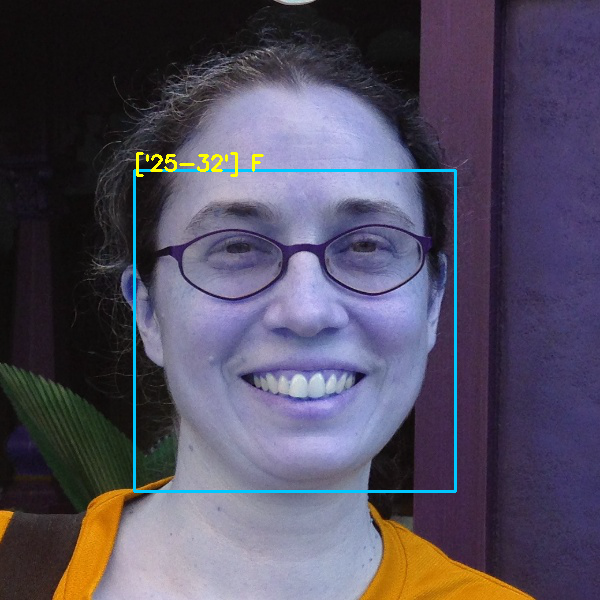

In [ ]:
import numpy
from google.colab.patches import cv2_imshow
frame=face_recognition.load_image_file('coarse_tilt_aligned_face.466.11107457115_d00543f21b_o.jpg')
face_locations = face_recognition.face_locations(frame)
print(face_locations)
cv2.rectangle(frame, (face_locations[0][3], face_locations[0][0]), (face_locations[0][1], face_locations[0][2]), (255, 200, 0), 2)
img=frame[face_locations[0][0]-25: face_locations[0][2]+25, face_locations[0][3]-25: face_locations[0][1]+25]
# predict ages and genders of the detected faces
img2= cv2.resize(img, (227, 227))
img2=np.array([img2]).reshape((1, 227,227,3))
results = gender_model.predict(img2)
predicted_genders = results[0]
gen="M" if predicted_genders[0] > 0.5 else "F"
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = age_model.predict(img2)
pred=""
pred=str(age_map[numpy.argmax(predicted_ages)])+" "+str(gen)
print(pred)
cv2.putText(frame, pred,(face_locations[0][3],face_locations[0][0]) , cv2.FONT_HERSHEY_SIMPLEX,0.7, (2, 255, 255), 2)
cv2_imshow(frame)

['25-32']
